In [46]:
from pystac_client import Client

In [47]:
client = Client.open("https://earth-search.aws.element84.com/v1")

In [48]:
bbox = [
  176.13470010353373,
  -85.035941506574,
  180,
  -84.59129667426426
]

In [205]:
search_results = client.search(
    collections=["sentinel-2-c1-l2a"],
    bbox=bbox,
    datetime="2024-01-29/2024-01-31",
)

In [1]:
# search_results.item_collection()

In [6]:
!wget {item['links'][0]['href']}

--2024-08-29 06:14:03--  https://earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a/items/S2A_T01CDK_20240131T174748_L2A
Resolving earth-search.aws.element84.com (earth-search.aws.element84.com)... 13.35.147.124, 13.35.147.49, 13.35.147.101, ...
Connecting to earth-search.aws.element84.com (earth-search.aws.element84.com)|13.35.147.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18016 (18K) [application/geo+json]
Saving to: ‘S2A_T01CDK_20240131T174748_L2A’

S2A_T01CDK_20240131 100%[===================>]  17.59K  --.-KB/s    in 0s      

2024-08-29 06:14:04 (90.1 MB/s) - ‘S2A_T01CDK_20240131T174748_L2A’ saved [18016/18016]



In [313]:
item = search_results.item_collection().items[0].to_dict()

In [314]:
# !gdalinfo {item['assets']['red']['href']}

Driver: GTiff/GeoTIFF
Files: none associated
Size is 10980, 10980
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 1S",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 1S",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-177,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PA

# read with dc_tools

In [225]:
from odc.apps.dc_tools import _stac

In [20]:
_stac.stac_transform(item)

TypeError: 'NoneType' object is not subscriptable

dc-tools can't convert this STAC -> eo-datasets

looks like it's missing top-level proj properties

In [280]:
item['properties']['proj:transform'] = item['assets']['red']['proj:transform']
item['properties']['proj:shape'] = item['assets']['red']['proj:shape']

In [281]:
_stac.stac_transform(item)

{'$schema': 'https://schemas.opendatacube.org/dataset',
 'id': '5c74ee3a-c7a7-529b-b6b8-5bb5360fb6d6',
 'crs': 'epsg:32701',
 'grids': {'g20m': {'shape': [5490, 5490],
   'transform': [20, 0, 399960, 0, -20, 1000000]},
  'g60m': {'shape': [1830, 1830],
   'transform': [60, 0, 399960, 0, -60, 1000000]},
  'default': {'shape': [10980, 10980],
   'transform': [10, 0, 399960, 0, -10, 1000000]}},
 'product': {'name': 'sentinel_2_c1_l2a'},
 'properties': {'created': '2024-01-31T22:52:39.205Z',
  'eo:platform': 'sentinel-2a',
  'eo:constellation': 'sentinel-2',
  'eo:instrument': 'MSI',
  'eo:cloud_cover': 79.617304,
  'proj:epsg': 32701,
  'proj:centroid': {'lat': -85.5728, 'lon': 0.11266},
  'mgrs:utm_zone': 1,
  'mgrs:latitude_band': 'C',
  'mgrs:grid_square': 'DK',
  'grid:code': 'MGRS-1CDK',
  'eo:azimuth': 271.90627562600105,
  'view:incidence_angle': 5.449097580851092,
  'eo:sun_azimuth': 98.5630913012375,
  'eo:sun_elevation': 16.2975389979203,
  's2:tile_id': 'S2A_OPER_MSI_L2A_TL_2AP

In [289]:
!cat ./datacube.conf

[default]
db_hostname: localhost
db_database: dearth
index_driver: default
db_username: dearth
db_password: dearthdbpassword


In [282]:
import datacube

In [290]:
dc = datacube.Datacube()

In [291]:
from odc.apps.dc_tools import stac_api_to_dc

In [293]:
from datacube.index.hl import Doc2Dataset

In [310]:
import pystac

In [322]:
stac_api_to_dc.process_item(rename_product="s2_l2a", item=pystac.read_dict(item), dc=dc, doc2ds=Doc2Dataset(dc.index), update_if_exists=False, allow_unsafe=False)

# querying with datacube

In [254]:
import datacube

In [321]:
dc = datacube.Datacube()

In [323]:
dc.load(product='s2_l2a')

ValueError: Product has no default CRS. 
Must specify 'output_crs' and 'resolution'

In [324]:
dc.load(product='s2_l2a', output_crs='epsg:32701', resolution=10)

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 1, y: 10980, x: 10980)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-31T17:48:09.956000
  * y            (y) float64 88kB 1e+06 1e+06 1e+06 ... 8.902e+05 8.902e+05
  * x            (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.098e+05
    spatial_ref  int32 4B 32701
Data variables: (12/15)
    coastal      (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    blue         (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    green        (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    red          (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    rededge1     (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    rededge2     (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    ...           ...
    nir09        (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    swir16       (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    swir22       (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    scl          (time, y, x) uint8 121MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    aot          (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    wvp          (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Attributes:
    crs:              EPSG:32701
    grid_mapping:     spatial_ref
    dc_partial_load:  True

In [326]:
dc.load(product='s2_l2a', output_crs='epsg:32701', resolution=10, x=(399960-10,509760+10), y=(890200-10,1000000+10))

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

In [328]:
dc.load(product='s2_l2a', output_crs='epsg:32701', resolution=10, x=(399960-10,509760+10), y=(890200-10,1000000+10), crs='epsg:32701')

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 1, y: 10982, x: 10982)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-31T17:48:09.956000
  * y            (y) float64 88kB 1e+06 1e+06 1e+06 ... 8.902e+05 8.902e+05
  * x            (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.098e+05 5.098e+05
    spatial_ref  int32 4B 32701
Data variables: (12/15)
    coastal      (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    blue         (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    green        (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    red          (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    rededge1     (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    rededge2     (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    ...           ...
    nir09        (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    swir16       (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    swir22       (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    scl          (time, y, x) uint8 121MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    aot          (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    wvp          (time, y, x) uint16 241MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Attributes:
    crs:              EPSG:32701
    grid_mapping:     spatial_ref
    dc_partial_load:  True

# landsat

In [196]:
search_results = client.search(
    collections=["landsat-c2-l2"],
    bbox=[163.16889775659703, -85.06, 180, -82.8533822917608],
    datetime="2022-01-17/2022-01-18",
)

In [198]:
item = search_results.item_collection().items[1].to_dict()

In [199]:
item['properties']['proj:epsg']

3031

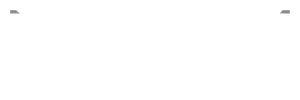

In [200]:
shape(item['geometry'])

In [201]:
item['geometry']

{'type': 'MultiPolygon',
 'coordinates': [[[[180, -82.56184317034021],
    [172.58920083445096, -82.56369252499033],
    [171.9670692852109, -83.14671138639494],
    [171.2901478826731, -83.76189374946806],
    [170.78244761081922, -84.40996416577417],
    [171.00030634501263, -84.41336577763231],
    [180, -84.40940838853632],
    [180, -82.56184317034021]]],
  [[[-180, -82.56184317034021],
    [-180, -84.40940838853632],
    [-171.93543651119455, -84.40586219942833],
    [-174.0699680740199, -82.56036333910032],
    [-180, -82.56184317034021]]]]}